<a href="https://colab.research.google.com/github/alexandre-braga/NumericalMethods-MAC026-BVP-Methods/blob/main/MAC026_Lista_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define funções:


In [2]:
def somatorio(x,t,alpha,m,L):
  sum_total = 0
  for nn in range(1, 1000):
      lam = (2*nn-1)*np.pi/(2*L)
      sum_total += ((-1)**(nn+1))/(2*nn-1) * np.exp(-alpha*(lam**2)*t) * np.cos(lam * x)
  return sum_total

def exata(x,t,alpha,m,L):
  sum = somatorio(x,t,alpha,m,L)
  result = (800/np.pi)*sum
  return result

def f(x,t):
  return 0

def phix(x,u):
  return 200

####Definição do Problema:

Domínio Espacial/Temporal:

In [3]:
# Dados do problema
L = 0.02
kappa = 10
rhoc = 10**7

# Dominio espacial
xi = 0
xf = L
nel = 5

# Dominio temporal
ti = 0
tf = 80
#tf = 100
#tf = 120

# Espaçamento entre os elementos espacial e temporal
h = (xf-xi)/nel
h2 = h*h
dt = 1
#dt = 0.1

Calculo do coeficiente difusivo:

In [4]:
# Coeficiente difusivo
alpha = kappa/rhoc
r = alpha*dt/h2

print('delta x =', h)
print('delta t =', dt)
print('r =', r)
print(2*alpha)
print(h2)
print(h2/(2*alpha))

delta x = 0.004
delta t = 1
r = 0.0625
2e-06
1.6e-05
8.0


Malha espacial e temporal:

In [5]:
J = nel+1
N = int(tf/dt)+1
x_grid = np.array([j*h for j in range(J)])
t_grid = np.array([n*dt for n in range(N)])

####Definição das Matrizes:

Define matriz tridiagonal, A e B

In [6]:
def tridiag(diag_lower, main_diag, diag_upper, k1=-1, k2=0, k3=1):
    return np.diag(diag_lower, k1) + np.diag(main_diag, k2) + np.diag(diag_upper, k3)

A = np.zeros((N-2,N-2))
AImp = np.zeros((N-2,N-2))
B = np.zeros((N-2,N-2))
b = np.zeros((N-2))

Define Matriz A (Imp):

In [7]:
subAImp = np.array([-r for i in range(J-3)])
mainAImp = np.array([1 + 2*r for i in range(J-2)])
AImp = tridiag(subAImp, mainAImp, subAImp)

print(AImp)

[[ 1.125  -0.0625  0.      0.    ]
 [-0.0625  1.125  -0.0625  0.    ]
 [ 0.     -0.0625  1.125  -0.0625]
 [ 0.      0.     -0.0625  1.125 ]]


Define Matriz A (CN):

In [8]:
subA = np.array([-r for i in range(J-3)])
mainA = np.array([2 + 2*r for i in range(J-2)])
A = tridiag(subA, mainA, subA)

print(A)

[[ 2.125  -0.0625  0.      0.    ]
 [-0.0625  2.125  -0.0625  0.    ]
 [ 0.     -0.0625  2.125  -0.0625]
 [ 0.      0.     -0.0625  2.125 ]]


Define Matriz B (CN):

In [9]:
subB = np.array([r for i in range(J-3)])
mainB = np.array([2 - 2*r for i in range(J-2)])
B = tridiag(subB, mainB, subB)

print(B)

[[1.875  0.0625 0.     0.    ]
 [0.0625 1.875  0.0625 0.    ]
 [0.     0.0625 1.875  0.0625]
 [0.     0.     0.0625 1.875 ]]


Define Matriz B (Exp):

In [10]:
subBExp = np.array([r for i in range(J-3)])
mainBExp = np.array([1 - 2*r for i in range(J-2)])
BExp = tridiag(subBExp, mainBExp, subBExp)

print(BExp)

[[0.875  0.0625 0.     0.    ]
 [0.0625 0.875  0.0625 0.    ]
 [0.     0.0625 0.875  0.0625]
 [0.     0.     0.0625 0.875 ]]


####Contribuição da Cond de Contorno Entrada (Neumman):

In [11]:
mainA[0] = 2 + r
mainAImp[0] = 1 + r

A = tridiag(subA, mainA, subA)
AImp = tridiag(subAImp, mainAImp, subAImp)

mainB[0] = 2 - r
mainBExp[0] = 1 - r

B = tridiag(subB, mainB, subB)
BExp = tridiag(subBExp, mainBExp, subBExp)

print(A)
print(AImp)
print(B)
print(BExp)

[[ 2.0625 -0.0625  0.      0.    ]
 [-0.0625  2.125  -0.0625  0.    ]
 [ 0.     -0.0625  2.125  -0.0625]
 [ 0.      0.     -0.0625  2.125 ]]
[[ 1.0625 -0.0625  0.      0.    ]
 [-0.0625  1.125  -0.0625  0.    ]
 [ 0.     -0.0625  1.125  -0.0625]
 [ 0.      0.     -0.0625  1.125 ]]
[[1.9375 0.0625 0.     0.    ]
 [0.0625 1.875  0.0625 0.    ]
 [0.     0.0625 1.875  0.0625]
 [0.     0.     0.0625 1.875 ]]
[[0.9375 0.0625 0.     0.    ]
 [0.0625 0.875  0.0625 0.    ]
 [0.     0.0625 0.875  0.0625]
 [0.     0.     0.0625 0.875 ]]


####Cálculo de $u$:

#####Explícito

$$T_i^{n+1} = BT_i^n$$
Com $T_i^{n} = u_i^{j}$
$$u_i^{j+1} = B u_i^j$$

In [12]:
uExp = np.zeros(shape=(J, N))

# Phix
uExp[:,0] = 200

# Condicoes de contorno de Dirichlet Saída
uExp[-1,:] = 0

for n in range(N-1):
    uExp[1:-1,n+1] = BExp.dot(uExp[1:-1,n])
    uExp[0,n+1] = uExp[1,n+1]
print(uExp[:,-1])

[135.12067575 135.12067575 119.15853931  88.82434549  47.44113682
   0.        ]


#####Implícito

$$A_{Imp}T_i^{n+1} = T_i^n$$
Com $T_i^{n} = u_i^{j}$
$$u_i^{j+1} = A_{Imp}^T \cdot u_i^j$$

In [13]:
uImp = np.zeros(shape=(J, N))

# Phix
uImp[:,0] = 200

# Condicoes de contorno de Dirichlet Saída
uImp[-1,:] = 0

for n in range(N-1):
    uImp[1:-1,n+1] = np.linalg.solve(AImp, uImp[1:-1,n])
    uImp[0,n+1] = uImp[1,n+1]
print(uImp[:,-1])

[135.59815973 135.59815973 119.70104472  89.36747232  47.79641029
   0.        ]


#####Crank-Nicholson

$$AT_i^{n+1} = BT_i^n$$
Com $T_i^{n} = u_i^{j}$
$$u_i^{j+1} = A^T \cdot B u_i^j$$

In [14]:
uCN = np.zeros(shape=(J, N))

# Phix
uCN[:,0] = 200

# Condicoes de contorno de Dirichlet Saída
uCN[-1,:] = 0

for n in range(N-1):
    uCN[1:-1,n+1] = np.linalg.solve(A, B.dot(uCN[1:-1,n]))
    uCN[0,n+1] = uCN[1,n+1]
print(uCN[:,-1])

[135.36346081 135.36346081 119.4305861   89.09318221  47.61567516
   0.        ]


####Cálculo da Exata e Plotagem:

In [15]:
xx = np.linspace(xi,xf,J)
exataxx = np.zeros(J)
for i in range(J):
  exataxx[i] = exata(xx[i],tf,alpha,nel,L)
print(exataxx)

[1.54462321e+02 1.47265437e+02 1.26080214e+02 9.23293043e+01
 4.88496120e+01 9.70306061e-15]


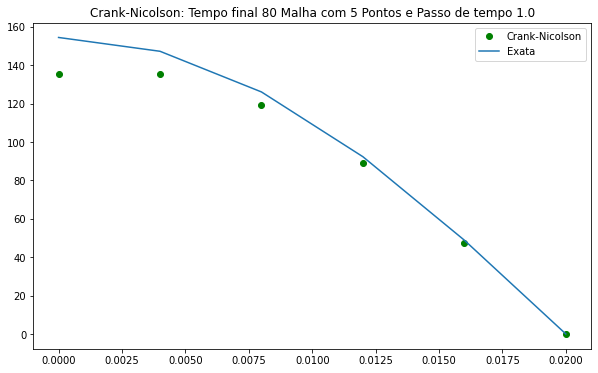

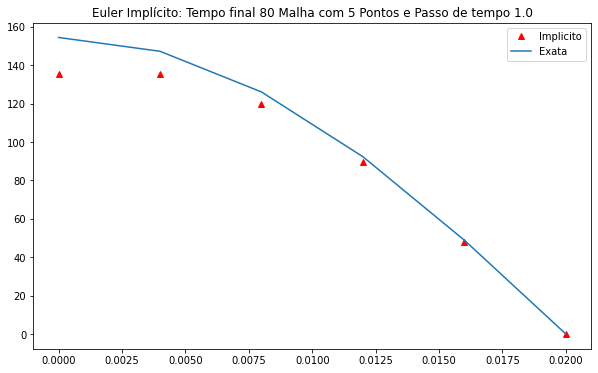

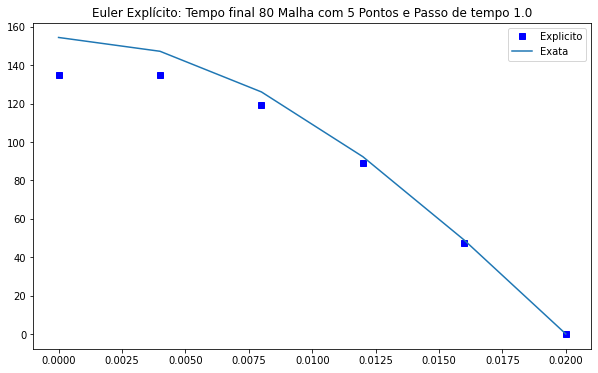

In [16]:
fig1, ax1 = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
fig3, ax3 = plt.subplots(figsize=(10, 6))

ax1.plot(xx,uCN[:,-1], 'go', label='Crank-Nicolson')
ax1.plot(xx,exataxx, label='Exata')
ax2.plot(xx,uImp[:,-1], 'r^', label='Implicito')
ax2.plot(xx,exataxx, label='Exata')
ax3.plot(xx,uExp[:,-1], 'bs', label='Explicito')
ax3.plot(xx,exataxx, label='Exata')

ax1.legend()
ax1.set_title("Crank-Nicolson: Tempo final %d" %tf + " Malha com %d Pontos" %nel + " e Passo de tempo %.1f" %dt)
ax2.legend()
ax2.set_title("Euler Implícito: Tempo final %d" %tf + " Malha com %d Pontos" %nel + " e Passo de tempo %.1f" %dt)
ax3.legend()
ax3.set_title("Euler Explícito: Tempo final %d" %tf + " Malha com %d Pontos" %nel + " e Passo de tempo %.1f" %dt)

fig1.show()
fig2.show()
fig3.show()